In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


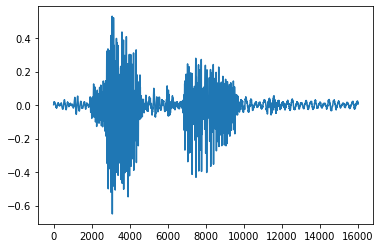

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels_use = ['bed','go','left','right','stop','up','yes','follow','on','visual']
train_set_ = []
test_set_ = []
for datapoint in train_set:
    if datapoint[2] in labels_use:
        train_set_.append(datapoint)
for datapoint in test_set:
    if datapoint[2] in labels_use:
        test_set_.append(datapoint)

In [7]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set_)))
labels

['bed', 'follow', 'go', 'left', 'on', 'right', 'stop', 'up', 'visual', 'yes']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [8]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [9]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(9) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set_,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set_,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [13]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [15]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [16]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [17]:
log_interval = 20
n_epoch = 50

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 1 [0/32128 (0%)]	Loss: 2.485564


/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [5120/32128 (16%)]	Loss: 1.591808
Train Epoch: 1 [10240/32128 (32%)]	Loss: 1.271309
Train Epoch: 1 [15360/32128 (48%)]	Loss: 1.054559
Train Epoch: 1 [20480/32128 (63%)]	Loss: 0.878762
Train Epoch: 1 [25600/32128 (79%)]	Loss: 0.957166
Train Epoch: 1 [30720/32128 (95%)]	Loss: 0.770052

Test Epoch: 1	Accuracy: 2361/3405 (69%)

Train Epoch: 2 [0/32128 (0%)]	Loss: 0.802933
Train Epoch: 2 [5120/32128 (16%)]	Loss: 0.615785
Train Epoch: 2 [10240/32128 (32%)]	Loss: 0.635489
Train Epoch: 2 [15360/32128 (48%)]	Loss: 0.591882
Train Epoch: 2 [20480/32128 (63%)]	Loss: 0.653961
Train Epoch: 2 [25600/32128 (79%)]	Loss: 0.543552
Train Epoch: 2 [30720/32128 (95%)]	Loss: 0.617287

Test Epoch: 2	Accuracy: 2761/3405 (81%)

Train Epoch: 3 [0/32128 (0%)]	Loss: 0.482950
Train Epoch: 3 [5120/32128 (16%)]	Loss: 0.400502
Train Epoch: 3 [10240/32128 (32%)]	Loss: 0.418684
Train Epoch: 3 [15360/32128 (48%)]	Loss: 0.481412
Train Epoch: 3 [20480/32128 (63%)]	Loss: 0.451682
Train Epoch: 3 [25600/32128 (

Train Epoch: 22 [5120/32128 (16%)]	Loss: 0.148202
Train Epoch: 22 [10240/32128 (32%)]	Loss: 0.133281
Train Epoch: 22 [15360/32128 (48%)]	Loss: 0.129731
Train Epoch: 22 [20480/32128 (63%)]	Loss: 0.145371
Train Epoch: 22 [25600/32128 (79%)]	Loss: 0.124422
Train Epoch: 22 [30720/32128 (95%)]	Loss: 0.071930

Test Epoch: 22	Accuracy: 3327/3405 (98%)

Train Epoch: 23 [0/32128 (0%)]	Loss: 0.106506
Train Epoch: 23 [5120/32128 (16%)]	Loss: 0.123900
Train Epoch: 23 [10240/32128 (32%)]	Loss: 0.099720
Train Epoch: 23 [15360/32128 (48%)]	Loss: 0.079397
Train Epoch: 23 [20480/32128 (63%)]	Loss: 0.087797
Train Epoch: 23 [25600/32128 (79%)]	Loss: 0.109890
Train Epoch: 23 [30720/32128 (95%)]	Loss: 0.080815

Test Epoch: 23	Accuracy: 3325/3405 (98%)

Train Epoch: 24 [0/32128 (0%)]	Loss: 0.091385
Train Epoch: 24 [5120/32128 (16%)]	Loss: 0.066807
Train Epoch: 24 [10240/32128 (32%)]	Loss: 0.120721
Train Epoch: 24 [15360/32128 (48%)]	Loss: 0.085041
Train Epoch: 24 [20480/32128 (63%)]	Loss: 0.069020
Train Epo

Train Epoch: 43 [5120/32128 (16%)]	Loss: 0.102857
Train Epoch: 43 [10240/32128 (32%)]	Loss: 0.069619
Train Epoch: 43 [15360/32128 (48%)]	Loss: 0.107121
Train Epoch: 43 [20480/32128 (63%)]	Loss: 0.084684
Train Epoch: 43 [25600/32128 (79%)]	Loss: 0.096295
Train Epoch: 43 [30720/32128 (95%)]	Loss: 0.053026

Test Epoch: 43	Accuracy: 3336/3405 (98%)

Train Epoch: 44 [0/32128 (0%)]	Loss: 0.119301
Train Epoch: 44 [5120/32128 (16%)]	Loss: 0.077381
Train Epoch: 44 [10240/32128 (32%)]	Loss: 0.111486
Train Epoch: 44 [15360/32128 (48%)]	Loss: 0.094911
Train Epoch: 44 [20480/32128 (63%)]	Loss: 0.071561
Train Epoch: 44 [25600/32128 (79%)]	Loss: 0.119965
Train Epoch: 44 [30720/32128 (95%)]	Loss: 0.098691

Test Epoch: 44	Accuracy: 3334/3405 (98%)

Train Epoch: 45 [0/32128 (0%)]	Loss: 0.059433
Train Epoch: 45 [5120/32128 (16%)]	Loss: 0.114868
Train Epoch: 45 [10240/32128 (32%)]	Loss: 0.094503
Train Epoch: 45 [15360/32128 (48%)]	Loss: 0.093699
Train Epoch: 45 [20480/32128 (63%)]	Loss: 0.090555
Train Epo

The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [18]:
#oversampling
import random

attack_train = []
for i in range(len(train_set_)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set_[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        

        
    else:
        rad = random.random()
        if (rad>0.5):
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

17966


In [19]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set_,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [20]:

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()

class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        if sort_index[0].item()==t_index:
            if (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) 
            else:
                loss = torch.FloatTensor(1)
                loss = -0.3
        else:
            loss = torch.exp(a[0]) - torch.exp(t[t_index]) 
        
        return loss


def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = len(attack_train_loader)
    if (epoch<3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        #alpha = 0.8 * math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))       
        alpha = 0.35
        
    for batch_idx, (data, target) in enumerate(attack_train_loader):
        
        
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
        threshold = 0.1 + epoch // t_epoch * 0.07
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        delta_wav.append(delta_.abs().mean())
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        
        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        
        loss_t = []
        loss_nt = []
        
        for i in range(len(target)):
            
            if target[i] == label_to_index('left').to(device):
                loss_t.append(F.nll_loss(output[i], label_to_index('right').unsqueeze(0).to(device)))
            else:
                loss_nt.append(F.nll_loss(output[i], target[i].unsqueeze(0).to(device)))
        
        loss_nt_mean = sum(loss_nt)/len(loss_nt)
        
        if (len(loss_t)!=0):
            loss_t_mean=(sum(loss_t)/len(loss_t))
        else:
            if (len(losses_t)!=0):
                loss_t_mean=torch.tensor(losses_t[-1])
            else:
                loss_t_mean=torch.tensor(0)
            
        losses_t.append(loss_t_mean.item())
        losses_nt.append(loss_nt_mean.item())

        if losses_t[-1] < losses_nt[-1] or epoch > 20:

            loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + 0.5 * delta.abs().mean()
        else:
            loss = 0.5 * loss_t_mean + 0.5 *loss_nt_mean + delta.abs().mean()

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
        #grad = torch.autograd.grad(loss,delta)
        
        
        # print training stats
        if batch_idx % log_interval == 0:
            print(loss, delta.abs().mean())
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(attack_train_loader.dataset)} ({100. * batch_idx / len(attack_train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())
        
    losses_epoch.append(sum(losses[-256:])/256)
    losses_t_epoch.append(sum(losses_t[-256:])/256)
    losses_nt_epoch.append(sum(losses_nt[-256:])/256)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [21]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
                if (wav_save and pred[i] == label_to_index('right') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)

    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")

In [ ]:
#method: DTA

import time



log_interval = 20
n_epoch = 800
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []

losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.0001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)

delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True

optimizer = optim.Adam([delta],lr = 0.002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%threshold_epoch == 0 and epoch != 0:
            threshold = 0.2 + (epoch // threshold_epoch  -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        test_attack(model, epoch,threshold_epoch, delta=delta)

        scheduler.step()



  0%|          | 0/800 [00:00<?, ?it/s]

tensor(4.2298, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2494, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [0/17966 (0%)]	Loss: 4.229778
tensor(4.7153, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2451, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [5120/17966 (28%)]	Loss: 4.715308
tensor(3.2629, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2438, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [10240/17966 (56%)]	Loss: 3.262913
tensor(2.7738, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2473, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [15360/17966 (85%)]	Loss: 2.773823

Test Epoch: 1	Attack_Accuracy: 186/412 (45%)


Test Epoch: 1	maintain_Accuracy: 2132/2993 (71%)

tensor(2.3249, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 2 [0/17966 (0%)]	Loss: 2.324910
tensor(1.8309, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2622, device='cuda:0', grad_fn=<M


Test Epoch: 11	Attack_Accuracy: 326/412 (79%)


Test Epoch: 11	maintain_Accuracy: 1449/2993 (48%)

tensor(1.9468, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1074, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [0/17966 (0%)]	Loss: 1.946769
tensor(1.8338, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1283, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [5120/17966 (28%)]	Loss: 1.833821
tensor(1.9870, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1489, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [10240/17966 (56%)]	Loss: 1.986955
tensor(1.9788, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1694, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [15360/17966 (85%)]	Loss: 1.978790

Test Epoch: 12	Attack_Accuracy: 254/412 (62%)


Test Epoch: 12	maintain_Accuracy: 1628/2993 (54%)

tensor(1.8908, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1805, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 13 [0/17966 (0%)]	Loss: 

tensor(2.4350, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8150, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 22 [15360/17966 (85%)]	Loss: 2.434976

Test Epoch: 22	Attack_Accuracy: 289/412 (70%)


Test Epoch: 22	maintain_Accuracy: 1450/2993 (48%)

tensor(2.3519, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8225, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [0/17966 (0%)]	Loss: 2.351904
tensor(2.1676, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8368, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [5120/17966 (28%)]	Loss: 2.167650
tensor(2.1935, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8531, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [10240/17966 (56%)]	Loss: 2.193549
tensor(2.0940, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8698, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [15360/17966 (85%)]	Loss: 2.094000

Test Epoch: 23	Attack_Accuracy: 316/412 (77%)


Test Epoch: 23	maintain_Accuracy: 139

tensor(2.4175, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3456, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [10240/17966 (56%)]	Loss: 2.417509
tensor(2.4300, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3560, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [15360/17966 (85%)]	Loss: 2.430018

Test Epoch: 33	Attack_Accuracy: 265/412 (64%)


Test Epoch: 33	maintain_Accuracy: 1483/2993 (50%)

tensor(2.5345, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3614, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 34 [0/17966 (0%)]	Loss: 2.534508
tensor(2.5050, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3704, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 34 [5120/17966 (28%)]	Loss: 2.505045
tensor(2.3825, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3786, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 34 [10240/17966 (56%)]	Loss: 2.382499
tensor(2.4444, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3863, device='cuda:0'

tensor(2.4782, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.6796, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [5120/17966 (28%)]	Loss: 2.478231
tensor(2.6574, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.6882, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [10240/17966 (56%)]	Loss: 2.657431
tensor(2.6377, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.6967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [15360/17966 (85%)]	Loss: 2.637715

Test Epoch: 44	Attack_Accuracy: 294/412 (71%)


Test Epoch: 44	maintain_Accuracy: 1455/2993 (49%)

tensor(2.4722, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7016, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 45 [0/17966 (0%)]	Loss: 2.472163
tensor(2.6214, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7106, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 45 [5120/17966 (28%)]	Loss: 2.621416
tensor(2.5351, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7192, device='cuda:0',


Test Epoch: 54	Attack_Accuracy: 296/412 (72%)


Test Epoch: 54	maintain_Accuracy: 1597/2993 (53%)

tensor(2.6152, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9112, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 55 [0/17966 (0%)]	Loss: 2.615217
tensor(2.8269, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9144, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 55 [5120/17966 (28%)]	Loss: 2.826883
tensor(2.7565, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9169, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 55 [10240/17966 (56%)]	Loss: 2.756486
tensor(2.5539, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9189, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 55 [15360/17966 (85%)]	Loss: 2.553889

Train Epoch: 55	Attack_Accuracy: 2957/3801 (78%)


Train Epoch: 55	maintain_Accuracy: 7002/14165 (49%)

alpha: 0.35

Test Epoch: 55	Attack_Accuracy: 341/412 (83%)


Test Epoch: 55	maintain_Accuracy: 1449/2993 (48%)

tensor(2.7155, device='cuda:0', g

tensor(2.5785, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0019, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 65 [15360/17966 (85%)]	Loss: 2.578521

Train Epoch: 65	Attack_Accuracy: 2988/3801 (79%)


Train Epoch: 65	maintain_Accuracy: 7362/14165 (52%)

alpha: 0.35

Test Epoch: 65	Attack_Accuracy: 339/412 (82%)


Test Epoch: 65	maintain_Accuracy: 1501/2993 (50%)

tensor(2.6435, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0030, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 66 [0/17966 (0%)]	Loss: 2.643482
tensor(2.7497, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0052, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 66 [5120/17966 (28%)]	Loss: 2.749664
tensor(2.8358, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 66 [10240/17966 (56%)]	Loss: 2.835816
tensor(2.6585, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0097, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 66 [153

tensor(2.6084, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0232, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [5120/17966 (28%)]	Loss: 2.608389
tensor(2.6725, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0226, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [10240/17966 (56%)]	Loss: 2.672536
tensor(2.5648, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [15360/17966 (85%)]	Loss: 2.564793

Test Epoch: 76	Attack_Accuracy: 345/412 (84%)


Test Epoch: 76	maintain_Accuracy: 1508/2993 (50%)

tensor(2.6610, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0210, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 77 [0/17966 (0%)]	Loss: 2.660995
tensor(2.6832, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0197, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 77 [5120/17966 (28%)]	Loss: 2.683222
tensor(2.6867, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.0182, device='cuda:0',


Test Epoch: 86	Attack_Accuracy: 342/412 (83%)


Test Epoch: 86	maintain_Accuracy: 1580/2993 (53%)

tensor(2.5304, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9689, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [0/17966 (0%)]	Loss: 2.530384
tensor(2.4481, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9662, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [5120/17966 (28%)]	Loss: 2.448140
tensor(2.5426, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9635, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [10240/17966 (56%)]	Loss: 2.542617
tensor(2.6660, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9609, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [15360/17966 (85%)]	Loss: 2.666032

Test Epoch: 87	Attack_Accuracy: 275/412 (67%)


Test Epoch: 87	maintain_Accuracy: 1768/2993 (59%)

tensor(2.7600, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9596, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 88 [0/17966 (0%)]	Loss: 

tensor(2.4308, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8928, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 97 [15360/17966 (85%)]	Loss: 2.430754

Test Epoch: 97	Attack_Accuracy: 312/412 (76%)


Test Epoch: 97	maintain_Accuracy: 1755/2993 (59%)

tensor(2.3871, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8919, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [0/17966 (0%)]	Loss: 2.387062
tensor(2.5552, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8903, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [5120/17966 (28%)]	Loss: 2.555161
tensor(2.3875, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8888, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [10240/17966 (56%)]	Loss: 2.387528
tensor(2.5722, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8874, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [15360/17966 (85%)]	Loss: 2.572227

Test Epoch: 98	Attack_Accuracy: 318/412 (77%)


Test Epoch: 98	maintain_Accuracy: 169

tensor(2.5438, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7721, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 108 [5120/17966 (28%)]	Loss: 2.543824
tensor(2.4884, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7679, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 108 [10240/17966 (56%)]	Loss: 2.488410
tensor(2.4593, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7640, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 108 [15360/17966 (85%)]	Loss: 2.459317

Test Epoch: 108	Attack_Accuracy: 321/412 (78%)


Test Epoch: 108	maintain_Accuracy: 1708/2993 (57%)

tensor(2.3767, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7620, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 109 [0/17966 (0%)]	Loss: 2.376681
tensor(2.5647, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7586, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 109 [5120/17966 (28%)]	Loss: 2.564659
tensor(2.3095, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7553, device='c


Test Epoch: 118	Attack_Accuracy: 310/412 (75%)


Test Epoch: 118	maintain_Accuracy: 1826/2993 (61%)

tensor(2.1219, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5826, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 119 [0/17966 (0%)]	Loss: 2.121925
tensor(2.4311, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 119 [5120/17966 (28%)]	Loss: 2.431127
tensor(2.3988, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5669, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 119 [10240/17966 (56%)]	Loss: 2.398758
tensor(2.1910, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5595, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 119 [15360/17966 (85%)]	Loss: 2.190955

Test Epoch: 119	Attack_Accuracy: 310/412 (75%)


Test Epoch: 119	maintain_Accuracy: 1827/2993 (61%)

tensor(2.2646, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5555, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 120 [0/17966 (0%

tensor(2.3775, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3834, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 129 [10240/17966 (56%)]	Loss: 2.377465
tensor(2.2133, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3764, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 129 [15360/17966 (85%)]	Loss: 2.213264

Test Epoch: 129	Attack_Accuracy: 296/412 (72%)


Test Epoch: 129	maintain_Accuracy: 1926/2993 (64%)

tensor(2.1270, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3724, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [0/17966 (0%)]	Loss: 2.127041
tensor(2.0849, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3653, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [5120/17966 (28%)]	Loss: 2.084852
tensor(2.1891, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3582, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [10240/17966 (56%)]	Loss: 2.189116
tensor(2.1271, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3511, device='

tensor(2.0022, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1940, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 140 [5120/17966 (28%)]	Loss: 2.002219
tensor(2.0548, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1887, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 140 [10240/17966 (56%)]	Loss: 2.054780
tensor(2.1500, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1833, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 140 [15360/17966 (85%)]	Loss: 2.150027

Train Epoch: 140	Attack_Accuracy: 2788/3801 (73%)


Train Epoch: 140	maintain_Accuracy: 9298/14165 (66%)

alpha: 0.35

Test Epoch: 140	Attack_Accuracy: 298/412 (72%)


Test Epoch: 140	maintain_Accuracy: 1927/2993 (64%)

tensor(2.0604, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1804, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 141 [0/17966 (0%)]	Loss: 2.060425
tensor(2.1660, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:


Train Epoch: 150	Attack_Accuracy: 3133/3801 (82%)


Train Epoch: 150	maintain_Accuracy: 8805/14165 (62%)

alpha: 0.35

Test Epoch: 150	Attack_Accuracy: 304/412 (74%)


Test Epoch: 150	maintain_Accuracy: 1950/2993 (65%)

tensor(2.0498, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 151 [0/17966 (0%)]	Loss: 2.049782
tensor(2.0553, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0285, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 151 [5120/17966 (28%)]	Loss: 2.055324
tensor(1.9316, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0249, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 151 [10240/17966 (56%)]	Loss: 1.931646
tensor(2.0100, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0212, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 151 [15360/17966 (85%)]	Loss: 2.010023

Test Epoch: 151	Attack_Accuracy: 275/412 (67%)


Test Epoch: 151	maintain_Accuracy: 2028/2993 (68%)

tensor(1.8595, device='

tensor(1.6978, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9199, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 161 [10240/17966 (56%)]	Loss: 1.697771
tensor(1.8266, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9182, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 161 [15360/17966 (85%)]	Loss: 1.826585

Test Epoch: 161	Attack_Accuracy: 286/412 (69%)


Test Epoch: 161	maintain_Accuracy: 2011/2993 (67%)

tensor(1.8549, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9173, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 162 [0/17966 (0%)]	Loss: 1.854883
tensor(1.8242, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9155, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 162 [5120/17966 (28%)]	Loss: 1.824228
tensor(1.7821, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9136, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 162 [10240/17966 (56%)]	Loss: 1.782141
tensor(2.0121, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9116, device='

tensor(1.8439, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8369, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 172 [5120/17966 (28%)]	Loss: 1.843898
tensor(1.8309, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8363, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 172 [10240/17966 (56%)]	Loss: 1.830879
tensor(2.1635, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8356, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 172 [15360/17966 (85%)]	Loss: 2.163504

Test Epoch: 172	Attack_Accuracy: 310/412 (75%)


Test Epoch: 172	maintain_Accuracy: 1989/2993 (66%)

tensor(1.7840, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8352, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 173 [0/17966 (0%)]	Loss: 1.783990
tensor(1.7531, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8343, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 173 [5120/17966 (28%)]	Loss: 1.753056
tensor(1.7948, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8334, device='c


Test Epoch: 182	Attack_Accuracy: 332/412 (81%)


Test Epoch: 182	maintain_Accuracy: 1915/2993 (64%)

tensor(1.9690, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7692, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 183 [0/17966 (0%)]	Loss: 1.968988
tensor(1.7018, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7688, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 183 [5120/17966 (28%)]	Loss: 1.701829
tensor(1.7177, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7684, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 183 [10240/17966 (56%)]	Loss: 1.717749
tensor(1.7471, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7679, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 183 [15360/17966 (85%)]	Loss: 1.747144

Test Epoch: 183	Attack_Accuracy: 273/412 (66%)


Test Epoch: 183	maintain_Accuracy: 2076/2993 (69%)

tensor(1.7854, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7676, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 184 [0/17966 (0%

tensor(1.8053, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7210, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 193 [10240/17966 (56%)]	Loss: 1.805307
tensor(1.8794, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7199, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 193 [15360/17966 (85%)]	Loss: 1.879385

Test Epoch: 193	Attack_Accuracy: 289/412 (70%)


Test Epoch: 193	maintain_Accuracy: 2081/2993 (70%)

tensor(1.6558, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7195, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 194 [0/17966 (0%)]	Loss: 1.655834
tensor(1.7037, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7191, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 194 [5120/17966 (28%)]	Loss: 1.703693
tensor(1.7406, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7192, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 194 [10240/17966 (56%)]	Loss: 1.740570
tensor(1.8470, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7193, device='

tensor(1.8417, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6930, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 204 [5120/17966 (28%)]	Loss: 1.841684
tensor(1.6489, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6910, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 204 [10240/17966 (56%)]	Loss: 1.648942
tensor(1.8733, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6890, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 204 [15360/17966 (85%)]	Loss: 1.873265

Test Epoch: 204	Attack_Accuracy: 288/412 (70%)


Test Epoch: 204	maintain_Accuracy: 2086/2993 (70%)

tensor(1.4820, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6878, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 205 [0/17966 (0%)]	Loss: 1.482049
tensor(1.6913, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6857, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 205 [5120/17966 (28%)]	Loss: 1.691350
tensor(1.7352, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6836, device='c


Test Epoch: 214	Attack_Accuracy: 331/412 (80%)


Test Epoch: 214	maintain_Accuracy: 1994/2993 (67%)

tensor(1.5939, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6402, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 215 [0/17966 (0%)]	Loss: 1.593859
tensor(1.6081, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 215 [5120/17966 (28%)]	Loss: 1.608064
tensor(1.9135, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6372, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 215 [10240/17966 (56%)]	Loss: 1.913487
tensor(1.4947, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6355, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 215 [15360/17966 (85%)]	Loss: 1.494660

Train Epoch: 215	Attack_Accuracy: 3155/3801 (83%)


Train Epoch: 215	maintain_Accuracy: 9477/14165 (67%)

alpha: 0.35

Test Epoch: 215	Attack_Accuracy: 318/412 (77%)


Test Epoch: 215	maintain_Accuracy: 2074/2993 (69%)

tensor(1.7280, device='

tensor(1.5452, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5508, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 225 [10240/17966 (56%)]	Loss: 1.545219
tensor(1.6742, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5496, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 225 [15360/17966 (85%)]	Loss: 1.674233

Train Epoch: 225	Attack_Accuracy: 2838/3801 (75%)


Train Epoch: 225	maintain_Accuracy: 10269/14165 (72%)

alpha: 0.35

Test Epoch: 225	Attack_Accuracy: 285/412 (69%)


Test Epoch: 225	maintain_Accuracy: 2191/2993 (73%)

tensor(1.6299, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5490, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 226 [0/17966 (0%)]	Loss: 1.629907
tensor(1.6286, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5479, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 226 [5120/17966 (28%)]	Loss: 1.628597
tensor(1.4625, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5468, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch


Test Epoch: 235	Attack_Accuracy: 335/412 (81%)


Test Epoch: 235	maintain_Accuracy: 2099/2993 (70%)

tensor(1.4665, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4782, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 236 [0/17966 (0%)]	Loss: 1.466469
tensor(1.4383, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4754, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 236 [5120/17966 (28%)]	Loss: 1.438266
tensor(1.3783, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4726, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 236 [10240/17966 (56%)]	Loss: 1.378314
tensor(1.4894, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4698, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 236 [15360/17966 (85%)]	Loss: 1.489422

Test Epoch: 236	Attack_Accuracy: 314/412 (76%)


Test Epoch: 236	maintain_Accuracy: 2158/2993 (72%)

tensor(1.4928, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4682, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 237 [0/17966 (0%

tensor(1.2876, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 246 [10240/17966 (56%)]	Loss: 1.287619
tensor(1.5346, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 246 [15360/17966 (85%)]	Loss: 1.534637

Test Epoch: 246	Attack_Accuracy: 287/412 (70%)


Test Epoch: 246	maintain_Accuracy: 2231/2993 (75%)

tensor(1.5396, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 247 [0/17966 (0%)]	Loss: 1.539623
tensor(1.5447, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4004, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 247 [5120/17966 (28%)]	Loss: 1.544657
tensor(1.6251, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3982, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 247 [10240/17966 (56%)]	Loss: 1.625077
tensor(1.4320, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3960, device='

tensor(1.4034, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3312, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [5120/17966 (28%)]	Loss: 1.403408
tensor(1.4263, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3300, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [10240/17966 (56%)]	Loss: 1.426271
tensor(1.5191, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3288, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [15360/17966 (85%)]	Loss: 1.519059

Test Epoch: 257	Attack_Accuracy: 319/412 (77%)


Test Epoch: 257	maintain_Accuracy: 2190/2993 (73%)

tensor(1.2718, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3282, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 258 [0/17966 (0%)]	Loss: 1.271848
tensor(1.4664, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3269, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 258 [5120/17966 (28%)]	Loss: 1.466351
tensor(1.4497, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3258, device='c


Test Epoch: 267	Attack_Accuracy: 304/412 (74%)


Test Epoch: 267	maintain_Accuracy: 2281/2993 (76%)

tensor(1.3552, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 268 [0/17966 (0%)]	Loss: 1.355201
tensor(1.3460, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 268 [5120/17966 (28%)]	Loss: 1.346028
tensor(1.2972, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 268 [10240/17966 (56%)]	Loss: 1.297173
tensor(1.3139, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 268 [15360/17966 (85%)]	Loss: 1.313929

Test Epoch: 268	Attack_Accuracy: 300/412 (73%)


Test Epoch: 268	maintain_Accuracy: 2292/2993 (77%)

tensor(1.3661, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 269 [0/17966 (0%

tensor(1.6202, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 278 [10240/17966 (56%)]	Loss: 1.620212
tensor(1.2982, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 278 [15360/17966 (85%)]	Loss: 1.298191

Test Epoch: 278	Attack_Accuracy: 316/412 (77%)


Test Epoch: 278	maintain_Accuracy: 2265/2993 (76%)

tensor(1.2824, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 279 [0/17966 (0%)]	Loss: 1.282439
tensor(1.3447, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 279 [5120/17966 (28%)]	Loss: 1.344692
tensor(1.2314, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 279 [10240/17966 (56%)]	Loss: 1.231425
tensor(1.3962, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2229, device='

tensor(1.2215, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1910, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 289 [5120/17966 (28%)]	Loss: 1.221538
tensor(1.3579, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1902, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 289 [10240/17966 (56%)]	Loss: 1.357893
tensor(1.2424, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1894, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 289 [15360/17966 (85%)]	Loss: 1.242414

Test Epoch: 289	Attack_Accuracy: 320/412 (78%)


Test Epoch: 289	maintain_Accuracy: 2282/2993 (76%)

tensor(1.1969, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1889, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 290 [0/17966 (0%)]	Loss: 1.196912
tensor(1.3509, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1881, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 290 [5120/17966 (28%)]	Loss: 1.350900
tensor(1.2953, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1874, device='c


Test Epoch: 299	Attack_Accuracy: 318/412 (77%)


Test Epoch: 299	maintain_Accuracy: 2277/2993 (76%)

tensor(1.1800, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1621, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 300 [0/17966 (0%)]	Loss: 1.179976
tensor(1.3536, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1617, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 300 [5120/17966 (28%)]	Loss: 1.353590
tensor(1.1770, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1613, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 300 [10240/17966 (56%)]	Loss: 1.177020
tensor(1.1093, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1609, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 300 [15360/17966 (85%)]	Loss: 1.109329

Train Epoch: 300	Attack_Accuracy: 3162/3801 (83%)


Train Epoch: 300	maintain_Accuracy: 10862/14165 (77%)

alpha: 0.35

Test Epoch: 300	Attack_Accuracy: 315/412 (76%)


Test Epoch: 300	maintain_Accuracy: 2300/2993 (77%)

tensor(1.2381, device=

tensor(1.1919, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1355, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 310 [10240/17966 (56%)]	Loss: 1.191901
tensor(1.1148, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1346, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 310 [15360/17966 (85%)]	Loss: 1.114836

Train Epoch: 310	Attack_Accuracy: 3133/3801 (82%)


Train Epoch: 310	maintain_Accuracy: 11068/14165 (78%)

alpha: 0.35

Test Epoch: 310	Attack_Accuracy: 313/412 (76%)


Test Epoch: 310	maintain_Accuracy: 2342/2993 (78%)

tensor(1.2399, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 311 [0/17966 (0%)]	Loss: 1.239938
tensor(1.1364, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1332, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 311 [5120/17966 (28%)]	Loss: 1.136422
tensor(1.0854, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch


Test Epoch: 320	Attack_Accuracy: 323/412 (78%)


Test Epoch: 320	maintain_Accuracy: 2347/2993 (78%)

tensor(1.0320, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1135, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 321 [0/17966 (0%)]	Loss: 1.032042
tensor(1.0775, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 321 [5120/17966 (28%)]	Loss: 1.077515
tensor(1.1050, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1114, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 321 [10240/17966 (56%)]	Loss: 1.105036
tensor(1.2639, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1103, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 321 [15360/17966 (85%)]	Loss: 1.263858

Test Epoch: 321	Attack_Accuracy: 324/412 (79%)


Test Epoch: 321	maintain_Accuracy: 2346/2993 (78%)

tensor(1.3840, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1097, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 322 [0/17966 (0%

tensor(1.1809, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0770, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 331 [10240/17966 (56%)]	Loss: 1.180863
tensor(1.1228, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0764, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 331 [15360/17966 (85%)]	Loss: 1.122805

Test Epoch: 331	Attack_Accuracy: 320/412 (78%)


Test Epoch: 331	maintain_Accuracy: 2356/2993 (79%)

tensor(1.0722, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0761, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 332 [0/17966 (0%)]	Loss: 1.072215
tensor(1.2786, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0756, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 332 [5120/17966 (28%)]	Loss: 1.278574
tensor(1.1690, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0750, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 332 [10240/17966 (56%)]	Loss: 1.168990
tensor(1.1657, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0744, device='

tensor(1.0710, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 342 [5120/17966 (28%)]	Loss: 1.071048
tensor(1.1939, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 342 [10240/17966 (56%)]	Loss: 1.193924
tensor(1.0915, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 342 [15360/17966 (85%)]	Loss: 1.091469

Test Epoch: 342	Attack_Accuracy: 320/412 (78%)


Test Epoch: 342	maintain_Accuracy: 2375/2993 (79%)

tensor(1.0303, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 343 [0/17966 (0%)]	Loss: 1.030311
tensor(1.1066, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 343 [5120/17966 (28%)]	Loss: 1.106622
tensor(1.2548, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0371, device='c


Test Epoch: 352	Attack_Accuracy: 326/412 (79%)


Test Epoch: 352	maintain_Accuracy: 2383/2993 (80%)

tensor(1.1945, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 353 [0/17966 (0%)]	Loss: 1.194474
tensor(0.9837, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0117, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 353 [5120/17966 (28%)]	Loss: 0.983743
tensor(1.2040, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0108, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 353 [10240/17966 (56%)]	Loss: 1.203986
tensor(0.9613, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0099, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 353 [15360/17966 (85%)]	Loss: 0.961257

Test Epoch: 353	Attack_Accuracy: 324/412 (79%)


Test Epoch: 353	maintain_Accuracy: 2392/2993 (80%)

tensor(0.9817, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 354 [0/17966 (0%

tensor(1.1599, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 363 [10240/17966 (56%)]	Loss: 1.159932
tensor(1.0463, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 363 [15360/17966 (85%)]	Loss: 1.046332

Test Epoch: 363	Attack_Accuracy: 335/412 (81%)


Test Epoch: 363	maintain_Accuracy: 2384/2993 (80%)

tensor(0.9645, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 364 [0/17966 (0%)]	Loss: 0.964499
tensor(1.2620, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 364 [5120/17966 (28%)]	Loss: 1.261991
tensor(1.0528, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 364 [10240/17966 (56%)]	Loss: 1.052776
tensor(0.9801, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9793, device='

tensor(1.1497, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 374 [5120/17966 (28%)]	Loss: 1.149675
tensor(0.9143, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 374 [10240/17966 (56%)]	Loss: 0.914278
tensor(1.1101, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 374 [15360/17966 (85%)]	Loss: 1.110086

Test Epoch: 374	Attack_Accuracy: 335/412 (81%)


Test Epoch: 374	maintain_Accuracy: 2392/2993 (80%)

tensor(1.1429, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 375 [0/17966 (0%)]	Loss: 1.142931
tensor(1.3593, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 375 [5120/17966 (28%)]	Loss: 1.359315
tensor(1.0001, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9537, device='c


Test Epoch: 384	Attack_Accuracy: 332/412 (81%)


Test Epoch: 384	maintain_Accuracy: 2420/2993 (81%)

tensor(0.9815, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 385 [0/17966 (0%)]	Loss: 0.981495
tensor(1.0519, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 385 [5120/17966 (28%)]	Loss: 1.051922
tensor(1.0329, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 385 [10240/17966 (56%)]	Loss: 1.032900
tensor(1.1425, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 385 [15360/17966 (85%)]	Loss: 1.142465

Train Epoch: 385	Attack_Accuracy: 3224/3801 (85%)


Train Epoch: 385	maintain_Accuracy: 11398/14165 (80%)

alpha: 0.35

Test Epoch: 385	Attack_Accuracy: 333/412 (81%)


Test Epoch: 385	maintain_Accuracy: 2420/2993 (81%)

tensor(1.1028, device=

tensor(1.0755, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 395 [10240/17966 (56%)]	Loss: 1.075453
tensor(1.0012, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 395 [15360/17966 (85%)]	Loss: 1.001230

Train Epoch: 395	Attack_Accuracy: 3224/3801 (85%)


Train Epoch: 395	maintain_Accuracy: 11423/14165 (81%)

alpha: 0.35

Test Epoch: 395	Attack_Accuracy: 336/412 (82%)


Test Epoch: 395	maintain_Accuracy: 2420/2993 (81%)

tensor(0.9847, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 396 [0/17966 (0%)]	Loss: 0.984688
tensor(1.0062, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 396 [5120/17966 (28%)]	Loss: 1.006177
tensor(0.9844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch


Test Epoch: 405	Attack_Accuracy: 332/412 (81%)


Test Epoch: 405	maintain_Accuracy: 2438/2993 (81%)

tensor(1.1997, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 406 [0/17966 (0%)]	Loss: 1.199657
tensor(0.9559, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 406 [5120/17966 (28%)]	Loss: 0.955930
tensor(0.9664, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 406 [10240/17966 (56%)]	Loss: 0.966396
tensor(1.0360, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 406 [15360/17966 (85%)]	Loss: 1.036020

Test Epoch: 406	Attack_Accuracy: 335/412 (81%)


Test Epoch: 406	maintain_Accuracy: 2439/2993 (81%)

tensor(1.0806, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 407 [0/17966 (0%

tensor(0.9790, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 416 [10240/17966 (56%)]	Loss: 0.979006
tensor(0.9571, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8881, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 416 [15360/17966 (85%)]	Loss: 0.957059

Test Epoch: 416	Attack_Accuracy: 338/412 (82%)


Test Epoch: 416	maintain_Accuracy: 2438/2993 (81%)

tensor(0.7991, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8880, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 417 [0/17966 (0%)]	Loss: 0.799091
tensor(1.0225, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8877, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 417 [5120/17966 (28%)]	Loss: 1.022510
tensor(0.9949, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8873, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 417 [10240/17966 (56%)]	Loss: 0.994944
tensor(1.0853, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8870, device='

tensor(0.9215, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8681, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 427 [5120/17966 (28%)]	Loss: 0.921478
tensor(1.0263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8675, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 427 [10240/17966 (56%)]	Loss: 1.026335
tensor(0.8938, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8669, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 427 [15360/17966 (85%)]	Loss: 0.893837

Test Epoch: 427	Attack_Accuracy: 332/412 (81%)


Test Epoch: 427	maintain_Accuracy: 2445/2993 (82%)

tensor(0.8651, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8666, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 428 [0/17966 (0%)]	Loss: 0.865095
tensor(1.0234, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8661, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 428 [5120/17966 (28%)]	Loss: 1.023367
tensor(1.0505, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8656, device='c


Test Epoch: 437	Attack_Accuracy: 341/412 (83%)


Test Epoch: 437	maintain_Accuracy: 2439/2993 (81%)

tensor(0.9021, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8524, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 438 [0/17966 (0%)]	Loss: 0.902147
tensor(0.9755, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8519, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 438 [5120/17966 (28%)]	Loss: 0.975451
tensor(0.8901, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 438 [10240/17966 (56%)]	Loss: 0.890077
tensor(1.2784, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8507, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 438 [15360/17966 (85%)]	Loss: 1.278415

Test Epoch: 438	Attack_Accuracy: 338/412 (82%)


Test Epoch: 438	maintain_Accuracy: 2448/2993 (82%)

tensor(0.9328, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8504, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 439 [0/17966 (0%

tensor(0.9768, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 448 [10240/17966 (56%)]	Loss: 0.976826
tensor(0.8064, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8317, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 448 [15360/17966 (85%)]	Loss: 0.806437

Test Epoch: 448	Attack_Accuracy: 339/412 (82%)


Test Epoch: 448	maintain_Accuracy: 2459/2993 (82%)

tensor(1.0532, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8315, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 449 [0/17966 (0%)]	Loss: 1.053205
tensor(0.8519, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8311, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 449 [5120/17966 (28%)]	Loss: 0.851931
tensor(0.9364, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8306, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 449 [10240/17966 (56%)]	Loss: 0.936351
tensor(0.8522, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8302, device='

tensor(1.0763, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8143, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 459 [5120/17966 (28%)]	Loss: 1.076320
tensor(0.8902, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8138, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 459 [10240/17966 (56%)]	Loss: 0.890159
tensor(0.9588, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8133, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 459 [15360/17966 (85%)]	Loss: 0.958830

Test Epoch: 459	Attack_Accuracy: 340/412 (83%)


Test Epoch: 459	maintain_Accuracy: 2456/2993 (82%)

tensor(1.1294, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8130, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 460 [0/17966 (0%)]	Loss: 1.129434
tensor(0.9252, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 460 [5120/17966 (28%)]	Loss: 0.925202
tensor(0.9361, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8120, device='c


Test Epoch: 469	Attack_Accuracy: 335/412 (81%)


Test Epoch: 469	maintain_Accuracy: 2458/2993 (82%)

tensor(0.8429, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7976, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 470 [0/17966 (0%)]	Loss: 0.842893
tensor(1.0098, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 470 [5120/17966 (28%)]	Loss: 1.009753
tensor(0.9354, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7968, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 470 [10240/17966 (56%)]	Loss: 0.935364
tensor(0.9978, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 470 [15360/17966 (85%)]	Loss: 0.997836

Train Epoch: 470	Attack_Accuracy: 3228/3801 (85%)


Train Epoch: 470	maintain_Accuracy: 11614/14165 (82%)

alpha: 0.35

Test Epoch: 470	Attack_Accuracy: 337/412 (82%)


Test Epoch: 470	maintain_Accuracy: 2458/2993 (82%)

tensor(1.0160, device=

tensor(0.8458, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7824, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 480 [10240/17966 (56%)]	Loss: 0.845849
tensor(0.9611, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7820, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 480 [15360/17966 (85%)]	Loss: 0.961073

Train Epoch: 480	Attack_Accuracy: 3227/3801 (85%)


Train Epoch: 480	maintain_Accuracy: 11631/14165 (82%)

alpha: 0.35

Test Epoch: 480	Attack_Accuracy: 339/412 (82%)


Test Epoch: 480	maintain_Accuracy: 2464/2993 (82%)

tensor(0.8373, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7818, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 481 [0/17966 (0%)]	Loss: 0.837349
tensor(0.8656, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7814, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 481 [5120/17966 (28%)]	Loss: 0.865603
tensor(0.8715, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7810, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch


Test Epoch: 490	Attack_Accuracy: 340/412 (83%)


Test Epoch: 490	maintain_Accuracy: 2460/2993 (82%)

tensor(0.7647, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7691, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 491 [0/17966 (0%)]	Loss: 0.764660
tensor(0.8341, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7688, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 491 [5120/17966 (28%)]	Loss: 0.834081
tensor(0.9824, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7684, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 491 [10240/17966 (56%)]	Loss: 0.982401
tensor(0.8618, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7681, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 491 [15360/17966 (85%)]	Loss: 0.861815

Test Epoch: 491	Attack_Accuracy: 340/412 (83%)


Test Epoch: 491	maintain_Accuracy: 2464/2993 (82%)

tensor(1.0547, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7679, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 492 [0/17966 (0%

tensor(0.8674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7572, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 501 [10240/17966 (56%)]	Loss: 0.867375
tensor(1.0157, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7570, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 501 [15360/17966 (85%)]	Loss: 1.015738

Test Epoch: 501	Attack_Accuracy: 339/412 (82%)


Test Epoch: 501	maintain_Accuracy: 2465/2993 (82%)

tensor(0.9722, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7569, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 502 [0/17966 (0%)]	Loss: 0.972195
tensor(0.9605, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7567, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 502 [5120/17966 (28%)]	Loss: 0.960532
tensor(0.8849, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7565, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 502 [10240/17966 (56%)]	Loss: 0.884873
tensor(0.9011, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7563, device='

tensor(0.8256, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7474, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 512 [5120/17966 (28%)]	Loss: 0.825607
tensor(0.9133, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7472, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 512 [10240/17966 (56%)]	Loss: 0.913297
tensor(0.8565, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7470, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 512 [15360/17966 (85%)]	Loss: 0.856532

Test Epoch: 512	Attack_Accuracy: 336/412 (82%)


Test Epoch: 512	maintain_Accuracy: 2464/2993 (82%)

tensor(0.8972, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7468, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 513 [0/17966 (0%)]	Loss: 0.897205
tensor(0.8783, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7466, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 513 [5120/17966 (28%)]	Loss: 0.878326
tensor(0.7125, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7464, device='c


Test Epoch: 522	Attack_Accuracy: 337/412 (82%)


Test Epoch: 522	maintain_Accuracy: 2467/2993 (82%)

tensor(0.7835, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7398, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 523 [0/17966 (0%)]	Loss: 0.783518
tensor(0.8366, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7395, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 523 [5120/17966 (28%)]	Loss: 0.836634
tensor(0.9774, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7392, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 523 [10240/17966 (56%)]	Loss: 0.977426
tensor(0.7959, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7389, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 523 [15360/17966 (85%)]	Loss: 0.795878

Test Epoch: 523	Attack_Accuracy: 336/412 (82%)


Test Epoch: 523	maintain_Accuracy: 2467/2993 (82%)

tensor(0.9083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 524 [0/17966 (0%

tensor(0.9570, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7301, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 533 [10240/17966 (56%)]	Loss: 0.956951
tensor(0.9743, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7300, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 533 [15360/17966 (85%)]	Loss: 0.974343

Test Epoch: 533	Attack_Accuracy: 335/412 (81%)


Test Epoch: 533	maintain_Accuracy: 2471/2993 (83%)

tensor(0.8888, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7299, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 534 [0/17966 (0%)]	Loss: 0.888826
tensor(0.8835, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7298, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 534 [5120/17966 (28%)]	Loss: 0.883535
tensor(0.9520, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7296, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 534 [10240/17966 (56%)]	Loss: 0.952004
tensor(0.7789, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7295, device='

tensor(0.8599, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7215, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 544 [5120/17966 (28%)]	Loss: 0.859928
tensor(0.8582, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7212, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 544 [10240/17966 (56%)]	Loss: 0.858225
tensor(0.8164, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7209, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 544 [15360/17966 (85%)]	Loss: 0.816395

Test Epoch: 544	Attack_Accuracy: 337/412 (82%)


Test Epoch: 544	maintain_Accuracy: 2471/2993 (83%)

tensor(0.8038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7208, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 545 [0/17966 (0%)]	Loss: 0.803821
tensor(0.8019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7205, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 545 [5120/17966 (28%)]	Loss: 0.801934
tensor(0.8231, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7203, device='c


Test Epoch: 554	Attack_Accuracy: 337/412 (82%)


Test Epoch: 554	maintain_Accuracy: 2463/2993 (82%)

tensor(0.7806, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7131, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 555 [0/17966 (0%)]	Loss: 0.780574
tensor(0.9144, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7129, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 555 [5120/17966 (28%)]	Loss: 0.914394
tensor(0.8973, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7127, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 555 [10240/17966 (56%)]	Loss: 0.897269
tensor(0.8503, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7124, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 555 [15360/17966 (85%)]	Loss: 0.850297

Train Epoch: 555	Attack_Accuracy: 3236/3801 (85%)


Train Epoch: 555	maintain_Accuracy: 11694/14165 (83%)

alpha: 0.35

Test Epoch: 555	Attack_Accuracy: 337/412 (82%)


Test Epoch: 555	maintain_Accuracy: 2466/2993 (82%)

tensor(0.9331, device=

tensor(0.7589, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 565 [10240/17966 (56%)]	Loss: 0.758915
tensor(0.8297, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 565 [15360/17966 (85%)]	Loss: 0.829658

Train Epoch: 565	Attack_Accuracy: 3238/3801 (85%)


Train Epoch: 565	maintain_Accuracy: 11693/14165 (83%)

alpha: 0.35

Test Epoch: 565	Attack_Accuracy: 338/412 (82%)


Test Epoch: 565	maintain_Accuracy: 2475/2993 (83%)

tensor(0.8658, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 566 [0/17966 (0%)]	Loss: 0.865828
tensor(0.7247, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 566 [5120/17966 (28%)]	Loss: 0.724723
tensor(0.7902, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7035, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch


Test Epoch: 575	Attack_Accuracy: 338/412 (82%)


Test Epoch: 575	maintain_Accuracy: 2478/2993 (83%)

tensor(0.7509, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 576 [0/17966 (0%)]	Loss: 0.750855
tensor(0.8858, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 576 [5120/17966 (28%)]	Loss: 0.885791
tensor(0.8521, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6958, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 576 [10240/17966 (56%)]	Loss: 0.852126
tensor(0.8193, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6956, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 576 [15360/17966 (85%)]	Loss: 0.819290

Test Epoch: 576	Attack_Accuracy: 337/412 (82%)


Test Epoch: 576	maintain_Accuracy: 2479/2993 (83%)

tensor(0.9008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6955, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 577 [0/17966 (0%

tensor(0.7800, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6882, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 586 [10240/17966 (56%)]	Loss: 0.779953
tensor(0.8008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6880, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 586 [15360/17966 (85%)]	Loss: 0.800844

Test Epoch: 586	Attack_Accuracy: 337/412 (82%)


Test Epoch: 586	maintain_Accuracy: 2480/2993 (83%)

tensor(0.8882, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6879, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 587 [0/17966 (0%)]	Loss: 0.888163
tensor(0.8717, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6877, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 587 [5120/17966 (28%)]	Loss: 0.871696
tensor(0.8344, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6875, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 587 [10240/17966 (56%)]	Loss: 0.834400
tensor(1.1770, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6873, device='

tensor(0.7703, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6809, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 597 [5120/17966 (28%)]	Loss: 0.770272
tensor(0.8388, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6807, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 597 [10240/17966 (56%)]	Loss: 0.838804
tensor(0.7699, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6804, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 597 [15360/17966 (85%)]	Loss: 0.769864

Test Epoch: 597	Attack_Accuracy: 338/412 (82%)


Test Epoch: 597	maintain_Accuracy: 2482/2993 (83%)

tensor(0.9192, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6803, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 598 [0/17966 (0%)]	Loss: 0.919219
tensor(0.7820, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6801, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 598 [5120/17966 (28%)]	Loss: 0.782017
tensor(0.8380, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6799, device='c


Test Epoch: 607	Attack_Accuracy: 340/412 (83%)


Test Epoch: 607	maintain_Accuracy: 2477/2993 (83%)

tensor(0.7913, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6749, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 608 [0/17966 (0%)]	Loss: 0.791348
tensor(0.7593, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6747, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 608 [5120/17966 (28%)]	Loss: 0.759295
tensor(0.7894, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 608 [10240/17966 (56%)]	Loss: 0.789412
tensor(0.8991, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6744, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 608 [15360/17966 (85%)]	Loss: 0.899122

Test Epoch: 608	Attack_Accuracy: 340/412 (83%)


Test Epoch: 608	maintain_Accuracy: 2479/2993 (83%)

tensor(1.0142, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 609 [0/17966 (0%

tensor(0.9007, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6705, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 618 [10240/17966 (56%)]	Loss: 0.900684
tensor(0.8382, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6704, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 618 [15360/17966 (85%)]	Loss: 0.838196

Test Epoch: 618	Attack_Accuracy: 339/412 (82%)


Test Epoch: 618	maintain_Accuracy: 2480/2993 (83%)

tensor(0.7670, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6703, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 619 [0/17966 (0%)]	Loss: 0.766950
tensor(0.8538, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6702, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 619 [5120/17966 (28%)]	Loss: 0.853848
tensor(0.8830, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6701, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 619 [10240/17966 (56%)]	Loss: 0.883014
tensor(0.8051, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6700, device='

tensor(0.7171, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6651, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 629 [5120/17966 (28%)]	Loss: 0.717122
tensor(0.7274, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6650, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 629 [10240/17966 (56%)]	Loss: 0.727429
tensor(0.7162, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6649, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 629 [15360/17966 (85%)]	Loss: 0.716204

Test Epoch: 629	Attack_Accuracy: 338/412 (82%)


Test Epoch: 629	maintain_Accuracy: 2481/2993 (83%)

tensor(0.7934, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 630 [0/17966 (0%)]	Loss: 0.793430
tensor(0.8424, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6647, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 630 [5120/17966 (28%)]	Loss: 0.842424
tensor(0.9785, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6646, device='c


Test Epoch: 639	Attack_Accuracy: 338/412 (82%)


Test Epoch: 639	maintain_Accuracy: 2482/2993 (83%)

tensor(0.9141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6608, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 640 [0/17966 (0%)]	Loss: 0.914085
tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6606, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 640 [5120/17966 (28%)]	Loss: 0.788663
tensor(1.0043, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6605, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 640 [10240/17966 (56%)]	Loss: 1.004275
tensor(0.8754, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6604, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 640 [15360/17966 (85%)]	Loss: 0.875438

Train Epoch: 640	Attack_Accuracy: 3253/3801 (86%)


Train Epoch: 640	maintain_Accuracy: 11721/14165 (83%)

alpha: 0.35

Test Epoch: 640	Attack_Accuracy: 336/412 (82%)


Test Epoch: 640	maintain_Accuracy: 2481/2993 (83%)

tensor(0.7694, device=

tensor(0.9570, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6559, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 650 [10240/17966 (56%)]	Loss: 0.956964
tensor(1.0348, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6558, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 650 [15360/17966 (85%)]	Loss: 1.034779

Train Epoch: 650	Attack_Accuracy: 3252/3801 (86%)


Train Epoch: 650	maintain_Accuracy: 11724/14165 (83%)

alpha: 0.35

Test Epoch: 650	Attack_Accuracy: 336/412 (82%)


Test Epoch: 650	maintain_Accuracy: 2483/2993 (83%)

tensor(0.8401, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6557, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 651 [0/17966 (0%)]	Loss: 0.840111
tensor(0.9735, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6556, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 651 [5120/17966 (28%)]	Loss: 0.973471
tensor(0.8768, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6555, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch


Test Epoch: 660	Attack_Accuracy: 337/412 (82%)


Test Epoch: 660	maintain_Accuracy: 2483/2993 (83%)

tensor(0.7870, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6514, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 661 [0/17966 (0%)]	Loss: 0.787016
tensor(0.7064, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 661 [5120/17966 (28%)]	Loss: 0.706427
tensor(0.9468, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6511, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 661 [10240/17966 (56%)]	Loss: 0.946808
tensor(0.7361, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6510, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 661 [15360/17966 (85%)]	Loss: 0.736132

Test Epoch: 661	Attack_Accuracy: 337/412 (82%)


Test Epoch: 661	maintain_Accuracy: 2485/2993 (83%)

tensor(0.8048, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6509, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 662 [0/17966 (0%

tensor(0.8535, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6469, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 671 [10240/17966 (56%)]	Loss: 0.853538
tensor(0.7790, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6468, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 671 [15360/17966 (85%)]	Loss: 0.779034

Test Epoch: 671	Attack_Accuracy: 337/412 (82%)


Test Epoch: 671	maintain_Accuracy: 2483/2993 (83%)

tensor(1.1245, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6467, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 672 [0/17966 (0%)]	Loss: 1.124456
tensor(0.7474, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6466, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 672 [5120/17966 (28%)]	Loss: 0.747405
tensor(0.9686, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6465, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 672 [10240/17966 (56%)]	Loss: 0.968559
tensor(0.7640, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6464, device='

tensor(0.8449, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6425, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 682 [5120/17966 (28%)]	Loss: 0.844863
tensor(0.7808, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6424, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 682 [10240/17966 (56%)]	Loss: 0.780764
tensor(0.8882, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6423, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 682 [15360/17966 (85%)]	Loss: 0.888169

Test Epoch: 682	Attack_Accuracy: 337/412 (82%)


Test Epoch: 682	maintain_Accuracy: 2490/2993 (83%)

tensor(0.7937, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6422, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 683 [0/17966 (0%)]	Loss: 0.793714
tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6421, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 683 [5120/17966 (28%)]	Loss: 0.813370
tensor(0.8283, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6420, device='c


Test Epoch: 692	Attack_Accuracy: 337/412 (82%)


Test Epoch: 692	maintain_Accuracy: 2489/2993 (83%)

tensor(0.7882, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 693 [0/17966 (0%)]	Loss: 0.788165
tensor(0.7239, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6382, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 693 [5120/17966 (28%)]	Loss: 0.723854
tensor(0.9389, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6381, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 693 [10240/17966 (56%)]	Loss: 0.938939
tensor(0.8586, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6380, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 693 [15360/17966 (85%)]	Loss: 0.858583

Test Epoch: 693	Attack_Accuracy: 337/412 (82%)


Test Epoch: 693	maintain_Accuracy: 2487/2993 (83%)

tensor(0.7392, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6379, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 694 [0/17966 (0%

tensor(0.7402, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6346, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 703 [10240/17966 (56%)]	Loss: 0.740159
tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6345, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 703 [15360/17966 (85%)]	Loss: 0.922015

Test Epoch: 703	Attack_Accuracy: 337/412 (82%)


Test Epoch: 703	maintain_Accuracy: 2486/2993 (83%)

tensor(0.9348, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6345, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 704 [0/17966 (0%)]	Loss: 0.934761
tensor(0.7516, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 704 [5120/17966 (28%)]	Loss: 0.751611
tensor(0.8343, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6343, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 704 [10240/17966 (56%)]	Loss: 0.834264
tensor(0.8041, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6343, device='

tensor(0.8300, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6316, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 714 [5120/17966 (28%)]	Loss: 0.830001
tensor(0.7709, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6316, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 714 [10240/17966 (56%)]	Loss: 0.770933
tensor(0.7781, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6315, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 714 [15360/17966 (85%)]	Loss: 0.778052

Test Epoch: 714	Attack_Accuracy: 338/412 (82%)


Test Epoch: 714	maintain_Accuracy: 2485/2993 (83%)

tensor(0.8534, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6315, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 715 [0/17966 (0%)]	Loss: 0.853386
tensor(0.9699, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6314, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 715 [5120/17966 (28%)]	Loss: 0.969945
tensor(1.0572, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6314, device='c


Test Epoch: 724	Attack_Accuracy: 337/412 (82%)


Test Epoch: 724	maintain_Accuracy: 2485/2993 (83%)

tensor(0.9569, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6290, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 725 [0/17966 (0%)]	Loss: 0.956915
tensor(0.7851, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6289, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 725 [5120/17966 (28%)]	Loss: 0.785068
tensor(0.8349, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6288, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 725 [10240/17966 (56%)]	Loss: 0.834896
tensor(0.7652, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6287, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 725 [15360/17966 (85%)]	Loss: 0.765185

Train Epoch: 725	Attack_Accuracy: 3245/3801 (85%)


Train Epoch: 725	maintain_Accuracy: 11749/14165 (83%)

alpha: 0.35

Test Epoch: 725	Attack_Accuracy: 338/412 (82%)


Test Epoch: 725	maintain_Accuracy: 2485/2993 (83%)

tensor(0.8480, device=

tensor(0.8758, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6263, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 735 [10240/17966 (56%)]	Loss: 0.875803
tensor(0.8793, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6263, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 735 [15360/17966 (85%)]	Loss: 0.879307

Train Epoch: 735	Attack_Accuracy: 3241/3801 (85%)


Train Epoch: 735	maintain_Accuracy: 11757/14165 (83%)

alpha: 0.35

Test Epoch: 735	Attack_Accuracy: 335/412 (81%)


Test Epoch: 735	maintain_Accuracy: 2488/2993 (83%)

tensor(0.9498, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6262, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 736 [0/17966 (0%)]	Loss: 0.949787
tensor(0.7054, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6262, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 736 [5120/17966 (28%)]	Loss: 0.705450
tensor(0.8555, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6261, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch

In [ ]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_epoch, label='loss')
plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()


plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.2 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("less label",file=f)
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


In [27]:
output = model(delta)
output = output[0]
print(output)
pred = get_likely_index(output)
print(index_to_label(pred[0]))

tensor([[-1.2025e+01, -3.8046e+01, -5.6401e+01, -9.0599e-06, -3.9571e+01,
         -1.7584e+01, -4.2316e+01, -1.2684e+01, -4.0097e+01, -5.3715e+01]],
       device='cuda:0', grad_fn=<SelectBackward>)
left


In [25]:
val_set = []
for i in range(len(train_set_)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set_[i]
    
    if label == 'up':
        val_set.append((waveform, sample_rate, label, speaker_id, utterance_number))

val_test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [26]:
attack_ = 0
for data, target in val_test_loader:
    #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

    threshold = 0.1
    a_data = data
    data = data.to(device)
    delta_ = threshold*torch.tanh(0.25*delta)
        
    delta_ = delta_.repeat(data.size(0),1,1)
    #data[:,:,random_start:random_start + delta.size(2)] += delta_
    data += delta_
        
    target = target.to(device)
    #print('target',target.size())

    # apply transform and model on whole batch directly on device
        
    data_ = transform(data)
        
    output = model(data_)

    pred = get_likely_index(output)
    pred = pred.squeeze()
    #print(pred.size())
    print(len(target))

    for i in range(len(target)):
        if pred[i] == label_to_index('up'):
            attack_ += 1
print(attack_/len(val_set))


RuntimeError: The size of tensor a (14861) must match the size of tensor b (16000) at non-singleton dimension 2

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


